#### Problem Statement

A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. To tackle this BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.

#### Objective : 
The objective is to predictively model the demand for shared bikes with the available independent variables which will be used by the management to understand:
1. Which variables are significant in predicting the demand for shared bikes.
2. How well those variables describe the bike demands 

#### Version
Title: Linear regression notebook\
Author: Swarnim Iyer\
Version: 1.0\
About: The linear regression notebook to predict the demand for rental bikes comprising the EDA, linear model, predictions and evaluation codes/scripts.

#### Data load
Load the required libraries and the given CSV required for the EDA exercise

In [147]:
#Load the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

#set the required  dataframe options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#remove the expected dataframe warnings
warnings.filterwarnings('ignore')

#Set the current date as a variable for analysis
current_date = pd.to_datetime('today').normalize()

In [148]:
#read the data(present as a csv)
df=pd.read_csv("day.csv")

#### Data Preprocessing
Initial exploration of the data with basic sanity checks and format changes

##### Inital schema exploration

In [149]:
#Get the shape of the data to check the volume of the data along with the fields at hand
df.shape

(730, 16)

In [150]:
#Identifying the datatypes of the columns available in the data
df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [151]:
# Getting a quick look at the sample of the data
df.head(2)

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   

   cnt  
0  985  
1  801

In [152]:
# Checking nulls in the records of the data
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [153]:
# Checking the unique records of the data
df.nunique()

instant       730
dteday        730
season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           594
windspeed     649
casual        605
registered    678
cnt           695
dtype: int64

##### Data cleanup

In [154]:
#classifying the columns into numerical,date and categorical cohorts
numerical=['temp','atemp','hum','windspeed','casual','registered','cnt']
categorical=['season','yr','mnth','holiday','weekday','workingday','weathersit']
date=['dteday']

In [155]:
#converting the dteday column to date
df['dteday']=pd.to_datetime(df['dteday'],format='%d-%m-%Y')

In [156]:
#Cross checking the yr,month column with the date column
print('Number of records with misclassification across 2018',len(df[(df['dteday'].dt.year==2018)&(df['yr']==1)]))
print('Number of records with misclassification across 2019',len(df[(df['dteday'].dt.year==2019)&(df['yr']==0)]))
print('Number of records with misclassification across months',len(df[df['dteday'].dt.month!=df['mnth']]))

Number of records with misclassification across 2018 0
Number of records with misclassification across 2019 0
Number of records with misclassification across months 0


In [157]:
#Cross checking the range of data present in the season, weekday data with the date column (considering yr in groupby)
print('Number of records with mismatch between dates and weekday column',len(df[df['dteday'].dt.weekday!=df['weekday']]))

Number of records with mismatch between dates and weekday column 424


In [158]:
#Fixing the working day flag based on the new weekday numbers (assuming the holiday list is correct)
df['weekday']=df['dteday'].dt.weekday
df['workingday']=np.where((df['weekday']==5) | (df['weekday']==6) | (df['holiday']==1),0,1)

##### Exploratory data exploration

In [159]:
# Getting the data distribution of the numerical columns
df[numerical].describe()

temp       atemp         hum   windspeed       casual  \
count  730.000000  730.000000  730.000000  730.000000   730.000000   
mean    20.319259   23.726322   62.765175   12.763620   849.249315   
std      7.506729    8.150308   14.237589    5.195841   686.479875   
min      2.424346    3.953480    0.000000    1.500244     2.000000   
25%     13.811885   16.889713   52.000000    9.041650   316.250000   
50%     20.465826   24.368225   62.625000   12.125325   717.000000   
75%     26.880615   30.445775   72.989575   15.625589  1096.500000   
max     35.328347   42.044800   97.250000   34.000021  3410.000000   

        registered          cnt  
count   730.000000   730.000000  
mean   3658.757534  4508.006849  
std    1559.758728  1936.011647  
min      20.000000    22.000000  
25%    2502.250000  3169.750000  
50%    3664.500000  4548.500000  
75%    4783.250000  5966.000000  
max    6946.000000  8714.000000

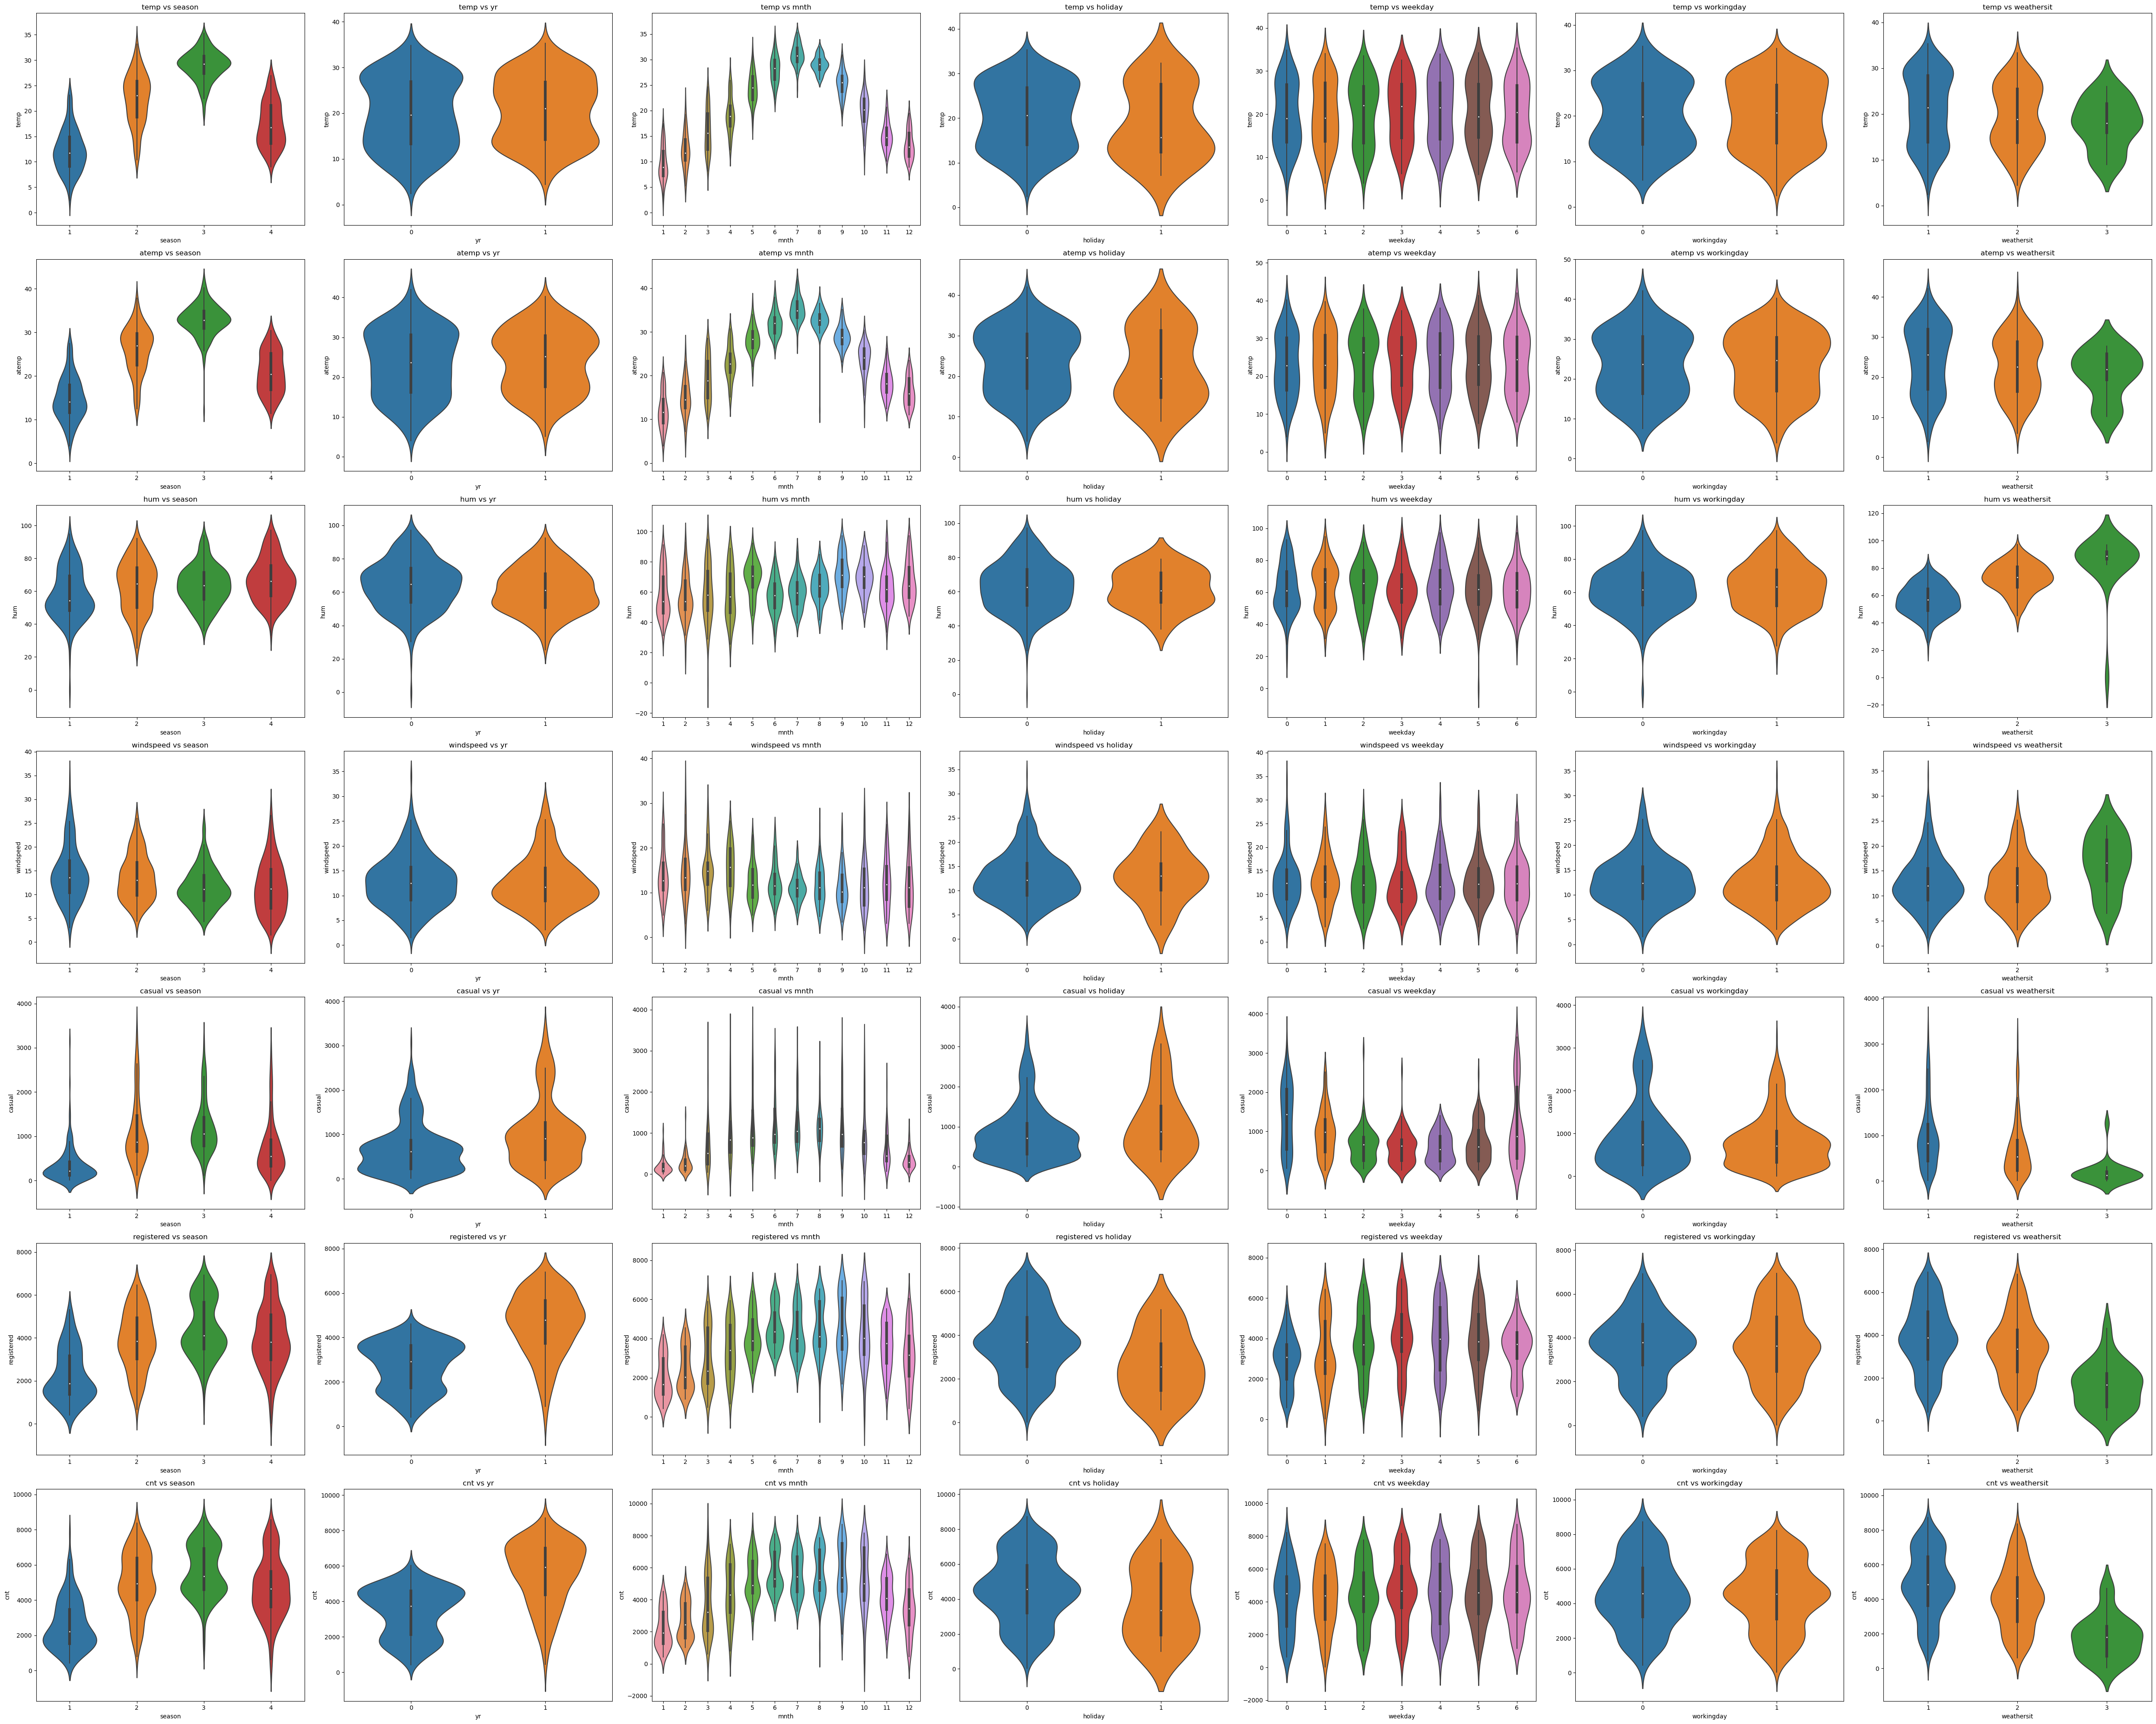

In [160]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=len(numerical), ncols=len(categorical), figsize=(50, 40), sharey=False)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Iterate over numerical variables and create violin plots for each combination of categorical variables
for i, numerical_var in enumerate(numerical):
    for j, categorical_var in enumerate(categorical):
        ax = axes[i * len(categorical) + j]
        sns.violinplot(x=categorical_var, y=numerical_var, data=df, ax=ax)
        ax.set_title(f'{numerical_var} vs {categorical_var}')
        ax.set_xlabel(categorical_var)
        ax.set_ylabel(numerical_var)

# Adjust layout to fit subplots nicely
plt.tight_layout()
plt.show()


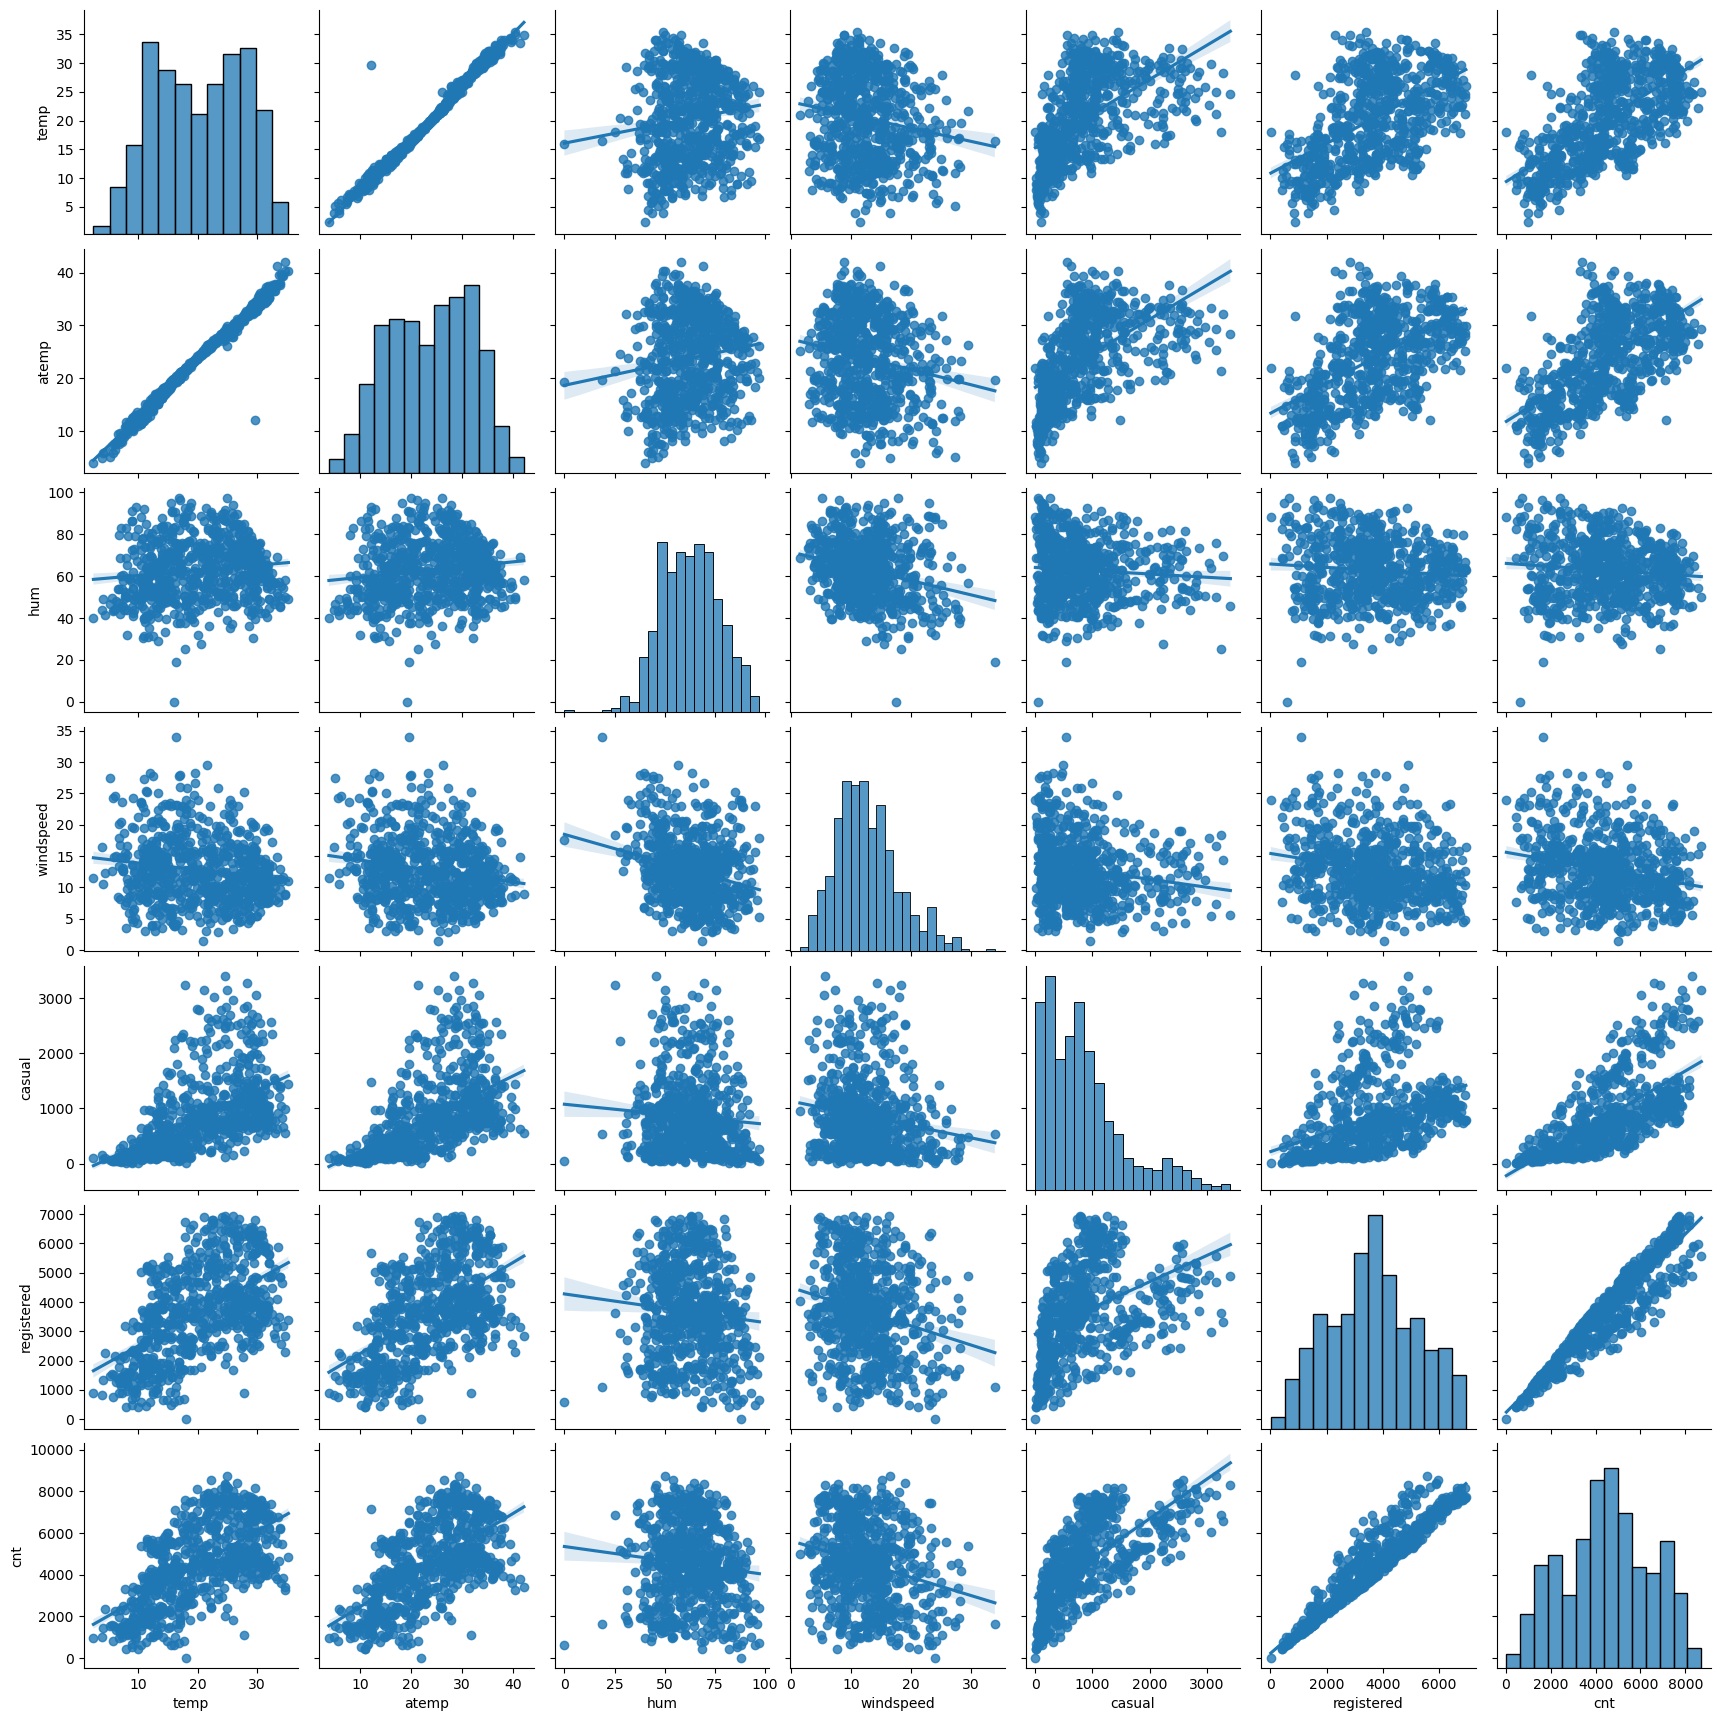

In [161]:
#Checking the pairplot distribution of the numerical variables for any patterns or trends
sns.pairplot(df[numerical], kind='reg')
plt.show()

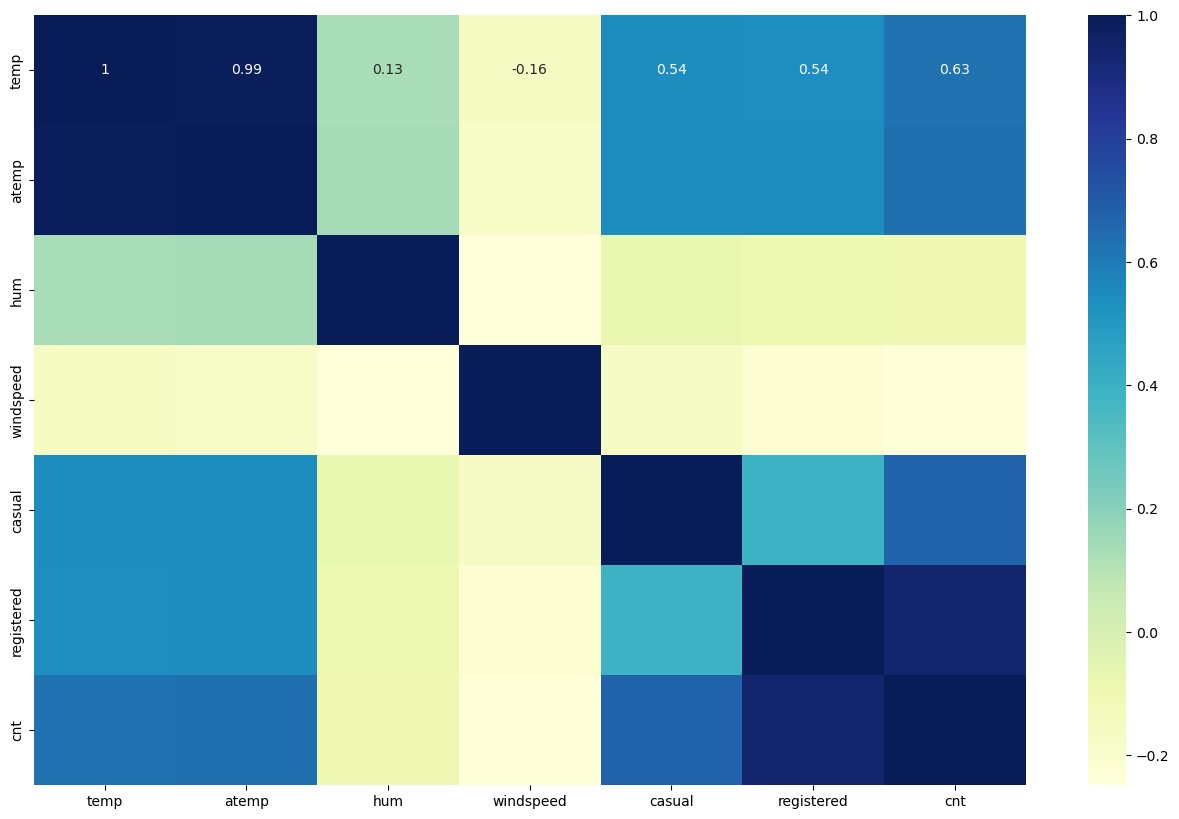

In [162]:
plt.figure(figsize = (16, 10))
sns.heatmap(df[numerical].corr(), annot = True, cmap="YlGnBu")
plt.show()

##### Dummy variable creation

In [163]:
#based on the observations from above we can have the following conclusions:
#temp and atemp are highly correlated and atemp can be removed as a input feature
#There are 3 variables present for the overall count/demand of bikes but only cnt can be taken as the target and rest needs to be removed (to avoid feature leakage)
#Dropping the date column from the input variables as well

#Performing the variable classification based on above observations
target=['cnt']
num_var=['temp','hum','windspeed']
flag_var=['yr','workingday','holiday']
dummy_var=['season','weathersit','mnth','weekday']

In [164]:
# creating the dummy variables through the variable list and using 'drop_first = True'
for i in dummy_var:
        intermediate = pd.get_dummies(df[i], drop_first = True,prefix=i).astype('int')
        df = pd.concat([df, intermediate], axis = 1)

#### Model training
Splitting the dataset in train and test split, scaling the data in required range and training the model with required variables selected

##### Train and test split

In [165]:
#Selected variables from the set of variables present
#here date variable and the encoded variabels are removed from the input
dependent_variable=['cnt']
num_var_final=['temp','hum','windspeed']
flag_var_final=['yr','workingday','holiday','season_2','season_3','season_4','weathersit_2','weathersit_3','mnth_2','mnth_3',
                'mnth_4','mnth_5','mnth_6','mnth_7','mnth_8','mnth_9','mnth_10','mnth_11','mnth_12','weekday_1','weekday_2',
                'weekday_3','weekday_4','weekday_5','weekday_6']
independent_variable=num_var_final+flag_var_final

In [166]:
#splitting the train and test datasets
df_train, df_test = train_test_split(df[dependent_variable+independent_variable], train_size = 0.7, test_size = 0.3, random_state = 100)

##### Data scaling

In [167]:
#scaling the required numerical features
scaler = MinMaxScaler()
df_train[dependent_variable+num_var_final] = scaler.fit_transform(df_train[dependent_variable+num_var_final])

In [168]:
#writing the variables in defined notions for ease of usage later
y_train = df_train[dependent_variable]
y_train=y_train.pop('cnt')
X_train = df_train[independent_variable]

##### Automated feature selection

In [169]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(estimator=lm, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('yr', True, 1),
 ('workingday', False, 9),
 ('holiday', True, 1),
 ('season_2', True, 1),
 ('season_3', False, 4),
 ('season_4', True, 1),
 ('weathersit_2', False, 2),
 ('weathersit_3', True, 1),
 ('mnth_2', False, 14),
 ('mnth_3', False, 5),
 ('mnth_4', False, 7),
 ('mnth_5', False, 6),
 ('mnth_6', False, 8),
 ('mnth_7', False, 15),
 ('mnth_8', True, 1),
 ('mnth_9', True, 1),
 ('mnth_10', False, 3),
 ('mnth_11', False, 16),
 ('mnth_12', False, 17),
 ('weekday_1', False, 19),
 ('weekday_2', False, 18),
 ('weekday_3', False, 12),
 ('weekday_4', False, 13),
 ('weekday_5', False, 10),
 ('weekday_6', False, 11)]

In [170]:
#taking only the required columns for the further model training
selected_features= X_train.columns[rfe.support_]

In [171]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[selected_features]

##### Initial model run

In [172]:
# Adding a constant variable and running the linear regression model
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit() 

#Checking the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     248.7
Date:                Wed, 07 Aug 2024   Prob (F-statistic):          1.16e-186
Time:                        19:01:59   Log-Likelihood:                 494.69
No. Observations:                 510   AIC:                            -967.4
Df Residuals:                     499   BIC:                            -920.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2762      0.026     10.565   

##### Multicollinearity check using VIF

In [173]:
#As per the p value in the summary all the variables are significant
# Hence calculating the VIFs to check for variable explainability
vif = pd.DataFrame()
X = X_train[selected_features]
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
1           hum  10.01
0          temp   8.51
2     windspeed   3.57
3            yr   2.01
5      season_2   1.81
6      season_4   1.74
8        mnth_8   1.57
9        mnth_9   1.30
7  weathersit_3   1.09
4       holiday   1.04

In [174]:
#Considering the high VIF values for 'hum' and 'temp'
#We'll drop 'hum' and check the VIF score again
selected_features=['temp','windspeed', 'yr', 'holiday', 'season_2', 'season_4','weathersit_3', 'mnth_8', 'mnth_9']

#Checking the VIF in case it's high again for 'temp'
vif = pd.DataFrame()
X = X_train[selected_features]
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0          temp  4.99
1     windspeed  3.01
2            yr  2.00
4      season_2  1.78
7        mnth_8  1.57
5      season_4  1.45
8        mnth_9  1.29
6  weathersit_3  1.06
3       holiday  1.04

##### Retraining with best features

In [175]:
#rerunning the model post the new feature list again
X_train_rfe=X_train[selected_features]
# Adding a constant variable and running the linear regression model
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit() 

#Checking the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     229.8
Date:                Wed, 07 Aug 2024   Prob (F-statistic):          2.24e-171
Time:                        19:01:59   Log-Likelihood:                 455.77
No. Observations:                 510   AIC:                            -891.5
Df Residuals:                     500   BIC:                            -849.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0897      0.017      5.151   

#### Residual analysis and model evaluation
Considering the R-Squared and even adjusted R-Squared values didn't drop significantly post the feature trimming, we've arrived at the best set of features for the count prediction. Now we'll look at the error terms distribution to ascertain whether our MLR assumptions holds true of not.

##### Residual distribution

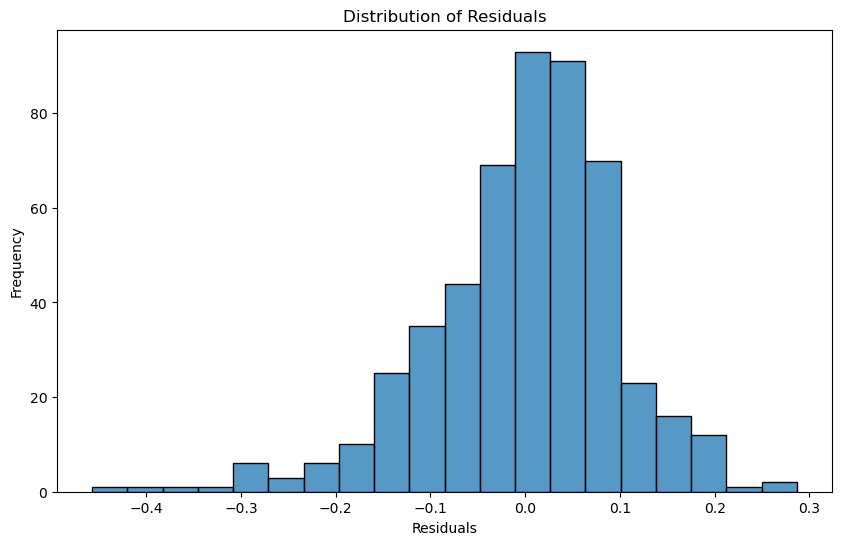

In [176]:
#getting the prediction out
y_train_cnt = lm.predict(X_train_rfe)

# Plot the histogram of the error terms
residuals= y_train-y_train_cnt
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=20)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

##### Test dataset scaling

In [177]:
#Scaling the test dataset results to perform the further validation
df_test[dependent_variable+num_var_final] = scaler.transform(df_test[dependent_variable+num_var_final])

##### Model validation

In [178]:
#Selection of the required features
y_test = df_test[dependent_variable]
y_test=y_test.pop('cnt')
X_test = df_test[selected_features]
X_test = sm.add_constant(X_test)

In [179]:
# Making predictions
y_pred = lm.predict(X_test)

In [180]:
#Fetching the r2 metrics for the test data (as the values are fairly consistent with the train data there is no overfitting in the above model)
r2_score(y_test, y_pred)

0.773606426251615

Text(0, 0.5, 'y_pred')

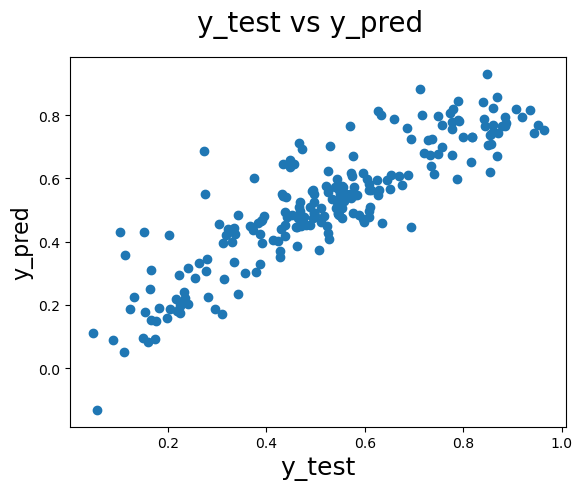

In [181]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20) 
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)